<a href="https://colab.research.google.com/github/tao-c/ml_notes/blob/master/FeatureSelectionPipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature selection is a decisive part of a machine learning pipeline: being too conservative means introducing unnecessary noise, while being too aggressive means throwing away useful information.

## In this post, we have seen how to use Boruta for performing a robust, statistically grounded feature selection on your dataset. Indeed, making substantial decisions about features is critical to ensure the success of your predictive model.

# https://miro.medium.com/max/2000/1*J-7kkseitdupEm5adCfHmw.png
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://my_site.com/my_picture.jpg")

In [20]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/2000/1*J-7kkseitdupEm5adCfHmw.png")

In [1]:
""" ***************************************************************************
# * File Description:                                                         *
# * Workflow for feature selection.                                           *
# *                                                                           *
# * The contents of this script are:                                          *
# * 1. Importing Libraries                                                    *
# * 2a. Get Madelon like data                                                 *
# * 2b. Define Helper Function to Create Skewed Distributions                 *
# * 2c. Create Critical Features                                              *
# * 2d. Set Critical Feature Thresholds and Create Labels                     *
# * 2e. Visualize Critical Features                                           *
# * 2f. Create Feature Matrix X_all and Target Column y_all                   *
# * 2g. Create train and test set                                             *
# * 3a. Exploratory Data Analysis: Correlation Matrix                         *
# * 3b. Exploratory Data Analysis: Box Plots                                  *
# * 4a. Feature Selection: Removing with a large fraction of constant values  *
# * 4b. Feature Selection: Removing highly correlated features                *
# * 4c. Feature Selection: Selecting relevant features                        *
# * 4d. Feature Selection: Dangers of a model that overfits                   *
# * 4e. Feature Selection: Tuning Estimator                                   *
# * 4f. Feature Selection: Selecting relevant features with tuned model       *
# * 4g. Feature Selection: Model evaluation with selected features            *
# * 5a. Feature Selection Pipeline: Removing Highly Correlated + RFE          *
# * 5b. Feature Selection: Model evaluation with selected features            *
# *                                                                           *
# * --------------------------------------------------------------------------*
# * AUTHORS(S): Frank Ceballos <frank.ceballos89@gmail.com>                   *
# * --------------------------------------------------------------------------*
# * DATE CREATED: February 08, 2020                                           *
# * --------------------------------------------------------------------------*
# * NOTES: None                                                               *
# * ************************************************************************"""


###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


###############################################################################
#                        2a. Get Madelon like data                            #
###############################################################################
# Define the number of features for each type
n_features = 100
n_informative = 10
n_redundant = 50
n_repeated = 25
n_useless = 15

# Create Labels
informative_labels = [f'Informative {ii}' for ii in range(1, n_informative + 1)]
redundant_labels = [f'Redundant {ii}' for ii in range(n_informative + 1, n_informative + n_redundant + 1)]
repeated_labels = [f'Repeated {ii}' for ii in range(n_informative + n_redundant+ 1, n_informative + n_redundant + n_repeated + 1)]
useless_labels = [f'Useless {ii}' for ii in range(n_informative + n_redundant + n_repeated + 1, n_features + 1)]
labels = informative_labels + redundant_labels + repeated_labels + useless_labels

# Get data
X_madelon, y_madelon = make_classification(n_samples = 1000, n_features = n_features,
                           n_informative = n_informative,
                           n_redundant = n_redundant , n_repeated = n_repeated,
                           n_clusters_per_class = 2, class_sep = 0.5, flip_y = 0.05,
                           random_state = 42, shuffle = False)


# Numpy array to pandas dataframe and series
X_madelon = pd.DataFrame(X_madelon, columns = labels)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
X_madelon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 100 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Informative 1   1000 non-null   float64
 1   Informative 2   1000 non-null   float64
 2   Informative 3   1000 non-null   float64
 3   Informative 4   1000 non-null   float64
 4   Informative 5   1000 non-null   float64
 5   Informative 6   1000 non-null   float64
 6   Informative 7   1000 non-null   float64
 7   Informative 8   1000 non-null   float64
 8   Informative 9   1000 non-null   float64
 9   Informative 10  1000 non-null   float64
 10  Redundant 11    1000 non-null   float64
 11  Redundant 12    1000 non-null   float64
 12  Redundant 13    1000 non-null   float64
 13  Redundant 14    1000 non-null   float64
 14  Redundant 15    1000 non-null   float64
 15  Redundant 16    1000 non-null   float64
 16  Redundant 17    1000 non-null   float64
 17  Redundant 18    1000 non-null   f

In [0]:
###############################################################################
#          2b. Define Helper Function to Create Skewed Distributions          #
###############################################################################
def randn_skew_fast(N, alpha=0.0, loc=0, scale=1.0):
    """
    Created a skewed distribution by randomly drawing from a skewed probability 
    densiy function.
    
    
    Parameters
    ----------
     N: int
        Number of points
    
    alpha: float
        Value describing the skeweness of the distribution. 
    
    loc: float
        Value describing the mean value of the skewed distribution
    
    scale: float
        Value describing the width of the skewed distribution
    
    
    Author Information
    ------------------
    jamesj629: <https://stackoverflow.com/users/266208/jamesj629>
    
    Source to original function: 
    <https://stackoverflow.com/questions/36200913/generate-n-random-numbers-from-a-skew-normal-distribution-using-numpy>
    """
    sigma = alpha / np.sqrt(1.0 + alpha**2) 
    u0 = np.random.randn(N)
    v = np.random.randn(N)
    u1 = (sigma*u0 + np.sqrt(1.0 - sigma**2)*v) * scale
    u1[u0 < 0] *= -1
    u1 = u1 + loc
    return u1


###############################################################################
#                       2c. Create Critical Features                          #
###############################################################################
# Set critical features distribution parameters
No_Critical_Features = 3
NUM_SAMPLES = 1000
SKEW_PARAMS = [0, 0, 0]
AVERAGE = [-10, 0, 10]
SEEDS = [42, 148, 526]
critical_features = []

# Create critical features
for ii in range(No_Critical_Features):
    # Set random seed
    np.random.seed(SEEDS[ii])
    
    # Set skewness and average value
    alpha_skew = SKEW_PARAMS[ii]
    average = AVERAGE[ii]
    
    # Get critical feature
    X_temp = randn_skew_fast(N = NUM_SAMPLES, alpha = alpha_skew, loc = average)
    
    # Append to critical feature list
    critical_features.append(X_temp)

In [0]:
###############################################################################
#            2d. Set Critical Feature Thresholds and Create Labels            #
###############################################################################
# Get critical labels
y_critical_1 = critical_features[0] < -8.3
y_critical_2 = critical_features[1] > -1.6
y_critical_3 = critical_features[2] > 8.3

# Save targets into a list
y_critical_targets = [y_critical_1, y_critical_2, y_critical_3]

# Define y_critical 
y_critical = y_critical_1*y_critical_2*y_critical_3*1


In [7]:
y_critical

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## As a sanity check, let’s visualize the distribution of the critical features.

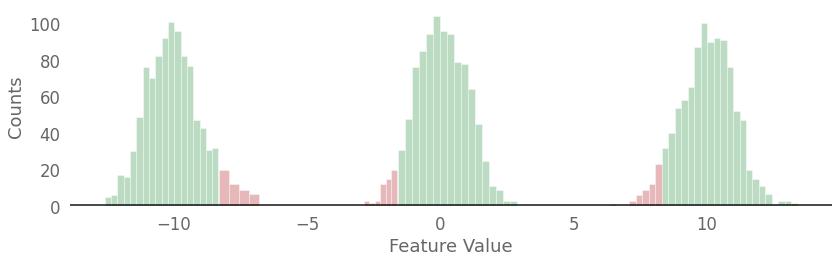

In [8]:
###############################################################################
#                       2e. Visualize Critical Features                       #
###############################################################################
# Set graph style
sns.set(font_scale = 1.5)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               'grid.linestyle': '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4', 'axes.grid': False})

# Set figure size
f, ax = plt.subplots(figsize=(12, 4))

for ii in range(No_Critical_Features):
    # Get critical features
    X_temp = critical_features[ii]
    y_temp = y_critical_targets[ii]
    
    # Get indices for true cases
    X_true = [X_temp[jj] for jj in range(len(y_temp)) if y_temp[jj] == 1]
    X_false = [X_temp[jj] for jj in range(len(y_temp)) if y_temp[jj] == 0]
    
    # Plot true values
    sns.distplot(X_true, color = 'g',  kde=False, ax = ax)
    sns.distplot(X_false, color = 'r',  kde=False, ax = ax)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Set axis labels
plt.xlabel('Feature Value')
plt.ylabel('Counts')

 # Tight layout
plt.tight_layout()

# Save figure
plt.savefig(f'Critical Feature Distribution.png', dpi = 1080)

## From Figure 1, you will notice there are three distinct Gaussian distributions. The leftmost distribution represents the first critical feature, the center-most distribution represents the second critical feature, and the rightmost distribution represents the third critical feature. The regions labeled as green denote the positive class in each feature and the regions labeled as red show the negative class.

# We are now ready to put everything together. In line 12 of Script 2f, we concatenate X_madelon and X_critical. Then in line 15–16, the target y_all is defined as the element-wise multiplication of y_madelon and y_critical.

In [9]:
ls

'Critical Feature Distribution.png'   sample_data/


In [0]:
###############################################################################
#           2f. Create Feature Matrix X_all and Target Column y_all           #
###############################################################################
# Define critical feature labels
critical_feature_labels =  [f'Critical {ii}' for ii in range(1, No_Critical_Features + 1)]

# Convert list to numpy arrays
X_critical = np.asarray(critical_features, dtype=np.float64).T
X_critical = pd.DataFrame(X_critical, columns = critical_feature_labels)

# Create feature matrix
X_all = pd.concat([X_madelon, X_critical], axis = 1)

# Create target
y_all = np.array([y_madelon[ii] * y_critical[ii] for ii in range(len(y_madelon))])

Before we move on, let’s review the group of features we have created:

X_madelon: This is a group of synthetic features that were created using the make_classification() class. In principle, the optimal number of features to select from this group should be the informative features (10 in total).

X_critical: The critical features are 3 in total. Each has Gaussian distribution with a different mean value. Each critical feature contains 90 % positive cases and 10 % false cases. By construction, these features might be hard to select by automated method; however, to a person with domain knowledge about the data at hand, these can easily be determined to be important to the outcome.

X_all: This is a group of features that contains both the X_madelon and X_critical features. The columns of this data set will be ordered as follows:

    Informative features — Columns 1–10: These features are highly related to the outcome and ideally should be the features you select.
    Redundant features — Columns 11–60: These features are made by linearly combining the informative features with different random weights. You can think of these as engineered features.
    Repeated features — Columns 61–85: These features are drawn randomly from either the informative or redundant features.
    Useless features — Columns 86–100: These features are filled with random noise.
    Critically important features — Columns 101–103: These features have Gaussian distribution and we will demand that they absolutely need to be included in the selected features.

Before we do anything else, let’s split our data. For each group of features, we will create a training and test set using a 70/30 split.

In [0]:
###############################################################################
#                       2g. Create train and test set                         #
###############################################################################
# Split the X_all and y_all
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, 
                                                                    test_size = 0.30,
                                                                    random_state = 42)

# Exploratory Data Analysis

In this section, we will visualize the data to confirm what we already know. We will start by exploring the correlation between our features. In Script 3a, we first we calculate the Spearman’s correlation matrix which values are in the range between -1 to 1 (line 5). A value of 1 signifies a strong positive correlation and value of -1 signifies a strong negative correlation. When the correlation value is close to zero, this means that no correlation exists between the features. Since negative and positive correlation are just correlations, we then take the absolute value of the correlation matrix (line 5)and the use seaborn package to create heatmap (line 14), see Figure 2.

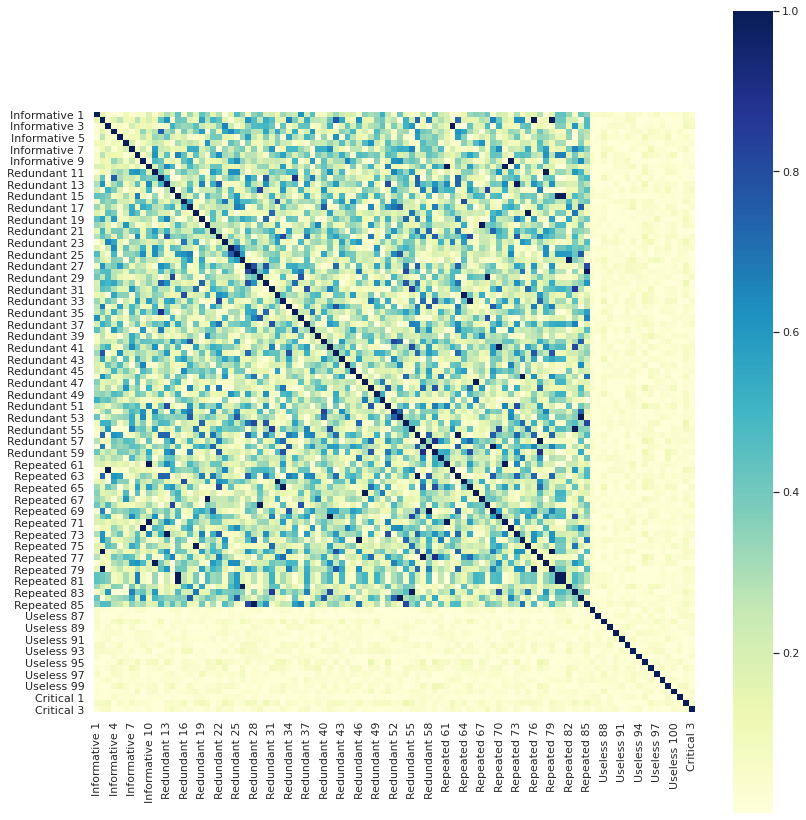

In [12]:
###############################################################################
#                3a. Exploratory Data Analysis: Correlation Matrix            #
###############################################################################
# Make correlation matrix
corr_matrix = X_all_train.corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 1)

# Set the figure size
f, ax = plt.subplots(figsize=(12, 12))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax)

# Tight layout
f.tight_layout()

# Save figure
f.savefig('correlation_matrix.png', dpi = 1080)


In [14]:
#https://miro.medium.com/max/2000/1*vuAO1Gc7WNZvvIXETaPghg.png
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/2000/1*vuAO1Gc7WNZvvIXETaPghg.png")

## In Figure 2, a light color signifies a low correlation and a dark blue color a high correlation. Notice how the informative features have low correlation with each other (upper left corner). The redundant features start showing a higher correlation (the heat map turns more blue in this region) like we expect it to happen. Additionally, some of the repeated are highly correlated with other features like we expected. Finally, the useless features and the critical are not correlated with other features. We know that the useless features are filled with random noise and should be not be correlated with the outcome. In the other hand, the critical features are correlated with the outcome, although they show no correlation with other features.

## Next let’s visualize the distribution of each feature using box plots. A box plot shows the quartiles of the data set and allows us to determine any anomalies and outliers in our data. In Script 3b, we first set the graph style, so that we don’t have the ugly gray default seaborn background in our figure (line 5–8). Then, we create a box plots figure for the features X_all_train (line 14).

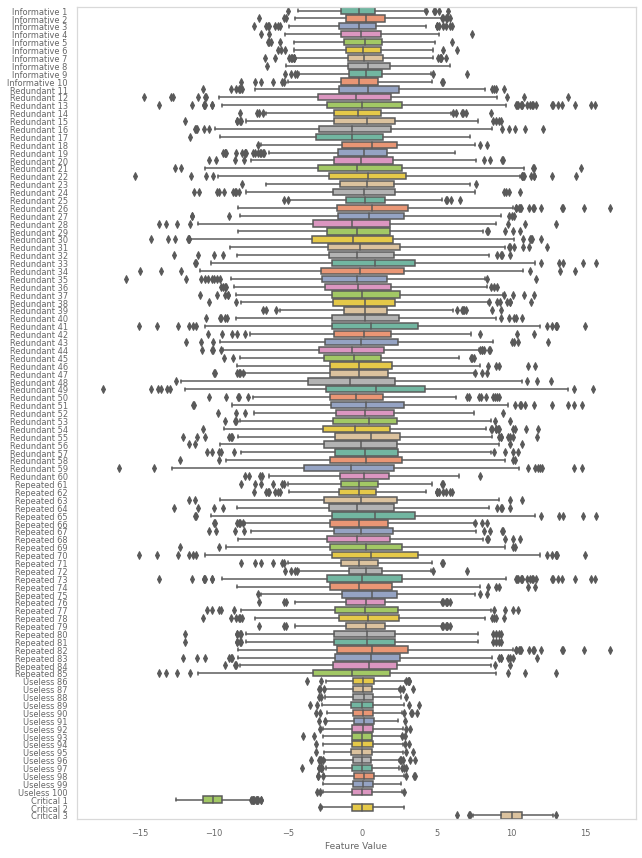

In [15]:
###############################################################################
#                  3b. Exploratory Data Analysis: Box Plots                   #
###############################################################################
# Set graph style
sns.set(font_scale = 0.75)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               'grid.linestyle': '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4', 'axes.grid': False})

# Create box plots based on feature type

# Set the figure size
f, ax = plt.subplots(figsize=(9, 12))
sns.boxplot(data=X_all_train, orient="h", palette="Set2")

# Set axis label
plt.xlabel('Feature Value')

# Tight layout
f.tight_layout()

# Save figure
f.savefig(f'Box Plots.png', dpi = 1080)

## In Figure 3, we can see that most features contain outliers. Moreover, all the Madelon-like features are centered around zero and most seem to have a Gaussian distribution. The critical features are centered around different mean values, like we showed before in Figure 1.

# Feature Selection

In this section, we will be using FeatureSelector, a tool that applies the following four feature selection methods:

    A filter method that removes features with a given fraction of repeated values.
    A filter method that removes correlated features based on Pearson or Spearman’s coefficient.
    A recursive feature elimination algorithm with cross validation that ranks features and determines the features that maximizes a model’s performance.
    The Boruta method which selects features that are relevant to the outcome.

## This tool is designed to apply different feature selection methods in a given sequence. For example, you could first remove correlated feature and then use recursive feature elimination to further reduce the amount of selected features.

# Removing Features with a Large Fraction of Constant Values

# One can argue that a feature that exhibit little to no variation as you change the samples will not be very useful for a model.

In Script 4a, we start by importing the feature selection tool. In line 7, we define a dict named step1 where we specify the feature selection method to apply and its parameters. For example, to remove features that have a large fraction of constant values (95 % or more), we set the key to 'Constant Features' and the value to {'frac_constant_values': 0.95}. In line 10, we save step1 in a list named steps, then we initiate an instance of FeatureSelector (line 13). The FeatureSelector haves a fit() and transform() method, much like Sklearn transformer. The fit() method learns which features to select from a training set (line 16) and the transform() method reduces a data set to only the selected features (line 19). The fit() method takes as input:

    X_all_train: a Pandas Dataframe
    y_all_train: a numpy array
    steps: a list of dictionaries

The transform() method takes as input:

    X_all_train: a Pandas Dataframe

In [0]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from boruta import BorutaPy

class FeatureSelector:
    """
    The FeatureSelector class implement the following feature selection 
    methods:
        
    
    1. A method that removes features with very similar values. For example,
    a feature that contains 0 for every instance.
    
    2. A filter method that removes correlated features based on Pearson or
    Spearman's coefficient.
    
    3. A recursive feature elimination algorithm with cross validation.
    
    4. The Boruta method which uncovers features that are relevant to
    the outcome.
    
    
    Parameters
    ----------
    
    None
        
    Example
    -------
    
    # Define steps
    step1 = {'Constant Features': {'frac_constant_values': 0.90}}
    
    step2 = {'Correlated Features': {'correlation_threshold': 0.95}}
    
    step3 = {'Relevant Features': {'estimator': estimator,
                                   'cv': 5,
                                    'n_estimators': 1000,
                                    'max_iter': 100,
                                    'verbose': 50,
                                    'random_state': 42}}
    
    step4 = {'RFECV Features': {'estimator': estimator,
                                'cv': 2,
                                'step': 1,
                                'scoring': 'accuracy',
                                'verbose': 50,}}
    
    # Place steps in a list in the order you want them execute it
    steps = [step1, step2, step3, step4]
    
    # Initialize FeatureSelector()
    fs = FeatureSelector()
    
    # Apply feature selection methods
    X_selected = fs.fit(X_all_train, y_all_train, steps)
    
    
    Attributes
    ----------
    
    
    Author Information
    ------------------
    Frank Ceballos
    LinkedIn: <https://www.linkedin.com/in/frank-ceballos/>
    Date: January 31, 2020
    """
    
    
    def __init__(self):
        self.rfecv = None
        self.selected_features = None
    
    
    def fit(self, X, y, steps = {}):
        """
        Calls the feature selection methods in the order specified in steps and
        determines the selected features. 
        
        
        Parameters
        ----------
        X : pandas dataframe
            A data set where each row is an observation and each column a feature.
        
        y: numpy array
            A numpy array containing the targets
            
        steps: list
            The list of steps that determines the order to apply the
            feature selection algorithms. Each element in this list is a dict,
            where key can be:
                            'Constant Features', 
                            'Correlated Features'
                            'Relevant Features'
                            'RFECV Features'
            and the value is a dict with the parameters used to execute 
            the feature selection method.
            
            
        Returns
        -------
        None
        """
        
        # Determine if there are any methods that are not defined
        for step in steps:
            available_methods = ['Constant Features', 'Correlated Features', 'Relevant Features', 'RFECV Features']
            
            for key, value in step.items():
                if key not in available_methods:
                    print(f'{key} is not a valid key!')
                    print(f'Only these are available: {available_methods}')
                    print(f'Redefine the key in this dict/step: {step}')
                    print('Now exiting function!')
                    return None
        
        # Get the order the methods are going to be applied
        method_order = [[*step][0] for step in steps]
        
        # Get methods
        ordered_methods = self.get_methods(method_order)
        
        # Initiate empty list of labels to drop
        drop_features = []
        
        # Temporary features
        X_temp = X.copy()
        
        for method_label in method_order:
            # Get method
            method = ordered_methods[method_label]
            
            # Get method parameters
            for step in steps:
                if method_label in step.keys():
                    params = step[method_label]
            
            
            # Determine features to drop
            if method_label in ['Constant Features', 'Correlated Features']:
                 # Message to user
                print(f'Removing {method_label}')
                drop_features_temp = method(X_temp, **params)
                print(drop_features_temp)
                print('')
                
                # Append features to drop list
                drop_features = drop_features + drop_features_temp
                
                # Update feature matrix
                X_temp = X.drop(columns = drop_features, axis = 1)
            
            elif method_label in ['Relevant Features']:
                print('Selecting relevant features')
                relevant_features_temp = method(X_temp, y, params)
                print(relevant_features_temp)
                print('')
                
                # Update feature matrix
                X_temp = X[relevant_features_temp]
            
            
            elif method_label in ['RFECV Features']:
                print('Selecting RFECV features')
                rfecv_features_temp, feature_selector = method(X_temp, y, params)
                print(rfecv_features_temp)
                print('')
                
                # Save fitted rfecv 
                self.rfecv = feature_selector
                
                # Update feature matrix
                X_temp = X[rfecv_features_temp]
        
        # Save selected features
        self.selected_features = list(X_temp.columns)
        
        # Message to user
        message = 'Done selecting features'
        
        return(print(message))
    
    def transform(self, X):
        """
        Returns a dataframe with the selected features determine with fit()
        
        
        Parameters
        ----------
        X : pandas dataframe
            A data set where ech row is an observation and each column a feature.
        
        Returns
        -------
        X_selected : pandas dataframe
            Dataframe with selected features
        """
        
        if self.selected_features == None:
            message = 'You first need to use the fit() method to determine the selected features!'
            return(print(message))
        else:
            # Get selected features
            X_selected = X[self.selected_features]
            return X_selected
            
        
        
    
    def get_methods(self, method_order):
        
        # Return feature selection methods in the order specified:
        ordered_methods = {}
        
        for method_label in method_order:
            
            if method_label == 'Constant Features':
                ordered_methods.update({method_label: constant_features})
            
            elif method_label == 'Correlated Features':
                ordered_methods.update({method_label: correlated_features})
            
            elif method_label == 'Relevant Features':
                ordered_methods.update({method_label: relevant_features})
                
            elif method_label == 'RFECV Features':
                ordered_methods.update({method_label: rfecv_features})
        
        return ordered_methods


def constant_features(X, frac_constant_values = 0.90):
    """
    Identifies features that have a large fraction of constant values.
    
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    frac_constant_values: float, optional (default = 0.90)
        The threshold used to identify features with a large fraction of 
        constant values.
        
    Returns
    -------
    labels: list
        A list with the labels identifying the features that contain a 
        large fraction of constant values.
    """
    
    # Get number of rows in X
    num_rows = X.shape[0]
    
    # Get column labels
    allLabels = X.columns.tolist()
    
    # Make a dict to store the fraction describing the value that occurs the most
    constant_per_feature = {label: X[label].value_counts().iloc[0]/num_rows for label in allLabels}
    
    # Determine the features that contain a fraction of missing values greater than
    # the specified threshold
    labels = [label for label in allLabels if constant_per_feature [label] > frac_constant_values]
    
    return labels


def correlated_features(X, correlation_threshold = 0.90):
    """
    Identifies features that are highly correlated. Let's assume that if
    two features or more are highly correlated, we can randomly select
    one of them and discard the rest without losing much information.
    
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    correlation_threshold: float, optional (default = 0.90)
        The threshold used to identify highly correlated features.
        
    Returns
    -------
    labels: list
        A list with the labels identifying the features that contain a 
        large fraction of constant values.
    """
    
    # Make correlation matrix
    corr_matrix = X.corr(method = "spearman").abs()
    
    
    # Select upper triangle of matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than correlation_threshold
    labels = [column for column in upper.columns if any(upper[column] >  correlation_threshold)]
    
    return labels


def relevant_features(X, y, params):
    """
    Determines the subset of features in X that are relevant to the outcome
    using the Boruta algorithm. The result are cross validated. 
        
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    y: numpy array
        A numpy array containing the targets
    
    params: dict,
        A dictionary containing the set of parameters use to initialize BorutaPy
        and determine the number of folds to use to validate the results.
    
    
    Examples
    --------
    # Initialize estimator
    estimator = RandomForestClassifier()
    
    # Define cv and BorutaPy parameters
     params = {'estimator': estimator,
               'cv': 5,
               'n_estimators': 1000,
               'max_iter': 100,
               'verbose': 50,
               'random_state': 42}
     
    # Get relevant feature labels
    labels = relevant_features(X = X, y = y, params = params)
    
    
    Returns
    -----
    labels: list
        A list with the labels identifying the relevant features in X.
    
    
    References
    ----------
    Find more details about Boruta here:
    https://github.com/scikit-learn-contrib/boruta_py
    
    """
    
    # Unpack params
    if 'cv' in params:
        cv = params['cv']
    else:
        cv = 5
    
    # Remove cv key from params so we can use with BorutaPy
    del params['cv']
    
    # Initiate variables
    feature_labels = list(X.columns)
    selected_features_mask = np.ones(len(feature_labels))
    counter = 0
      
    #Get K-folds indices
    kf = KFold(n_splits = cv)
    kf.get_n_splits(X)
    
    # Initiate progress bar
    status.printProgressBar(counter, cv, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    # K-fold cross validation
    for train_index, val_index in kf.split(X):
        # Get train fold data
        X_train_fold = X.iloc[train_index, :]
        y_train_fold = y[train_index]
        
        # Define Boruta feature selection method
        feat_selector = BorutaPy(**params)
        
        # Find all relevant features
        feat_selector.fit(X_train_fold.values, y_train_fold)
        
        # Boruta selected feature mask
        selected_features_temp = feat_selector.support_
        
        # Update selected relevant features
        selected_features_mask = selected_features_mask*selected_features_temp
        
        # Update progress bar
        counter += 1
        status.printProgressBar(counter, cv, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    # Boruta selected feature labels
    labels = [feature_labels[ii] for ii in range(len(feature_labels)) if  selected_features_mask[ii] == 1]
    
    return labels


def rfecv_features(X, y, rfecv_params):
    """
    Feature ranking with recursive feature elimination and cross-validated 
    selection of the best number of features. Determines the minimum number
    of features that are needed to maxmize the model's performance. 
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    y: numpy array
        A numpy array containing the targets
    
    rfecv_params: dict,
        A dictionary containing the set of parameters use to initialize RFECV sklearn
        class.
    
    
    Examples
    --------
    # Initialize estimator
    estimator = RandomForestClassifier()
    
    # Define RFECV parameters
    rfecv_params = {'estimator': estimator,
                    'cv': 2,
                    'step': 1,
                    'scoring': 'accuracy',
                    'verbose': 50}
    
    # Get rfecv feature labels
    labels = rfecv_features(X = X, y = y, rfecv_params = rfecv_params)
    
    
    Returns
    -----
    labels: list
        A list with the labels identifying the subset of features needed
        to maximize the model's performance.
    
    feature_selector: fitted RFECV object
    
    
    References
    ----------
    Find more details about Boruta here:
    https://github.com/scikit-learn-contrib/boruta_py
    
    """
    
    # Initialize RFECV object
    feature_selector = RFECV(**rfecv_params)
    
    # Fit RFECV
    feature_selector.fit(X, y)
    
    # Get selected features
    feature_labels = X.columns
    
    # Get selected features
    labels = feature_labels[feature_selector.support_].tolist()
    
    return labels, feature_selector


class status:
    """  Report progress of process. """
    
    def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
        """
        Call in a loop to create terminal progress bar
        
        Parameters
        ----------
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
            
        Examples
        --------
        from time import sleep
        # A List of Items
        items = list(range(0, 57))
        l = len(items)
        
        # Initial call to print 0% progress
        printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        for i, item in enumerate(items):
            # Do stuff...
            sleep(0.1)
            # Update Progress Bar
            printProgressBar(i + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
            
        References
        ----------
        Original Source: https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
        """
        
        
        percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
        filledLength = int(length * iteration // total)
        bar = fill * filledLength + '-' * (length - filledLength)
        print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
        # Print New Line on Complete
        if iteration == total: 
            print()

In [22]:
###############################################################################
#  4a. Feature Selection: Removing with a large fraction of constant values   #
###############################################################################
#from tools.data_processing import FeatureSelector

# Define steps
step1 = {'Constant Features': {'frac_constant_values': 0.95}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)

Removing Constant Features
[]

Done selecting features


# The output of fit will be print out to the consoles the features that were removed. In this case, you can see an empty list being displayed which signifies that no features were removed in this step.

## Removing Correlated Features

Let’s assume that if a group of features is highly correlated, we can randomly select one of them and discard the rest without losing much information. To measure the correlation between features, we will use Spearman’s correlation coefficient. To remove correlated features, we will again use FeatureSelector. In Script 4b, we start by defining a dict that describes feature selection method and its parameters. For example, in this case we set the key to 'Correlated Features' and the value to {'correlation_threshold': 0.95}. This algorithm will group features that share a correlation value of 0.95 or greater. Then for each group of correlated features one feature is selected and the rest are discarded. In line 8, we save step1 in a list, then initialize an instance of FeatureSelector (line 11). Finally, we fit the FeatureSelector and transform our data.

In [16]:
!pip install boruta

     |████████████████████████████████| 61kB 4.5MB/s 


In [0]:
import pandas as pd### make X and y
X = pd.DataFrame({'age': [25, 32, 47, 51, 62],
                  'height': [182, 176, 174, 168, 181],
                  'weight': [75, 71, 78, 72, 86]})
y = pd.Series([20, 32, 45, 55, 61], name = 'income')

In [19]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))### print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: []
features in the blue area: []


# Removing Correlated Features

## Let’s assume that if a group of features is highly correlated, we can randomly select one of them and discard the rest without losing much information. To measure the correlation between features, we will use Spearman’s correlation coefficient. To remove correlated features, we will again use FeatureSelector. In Script 4b, we start by defining a dict that describes feature selection method and its parameters. For example, in this case we set the key to 'Correlated Features' and the value to {'correlation_threshold': 0.95}. This algorithm will group features that share a correlation value of 0.95 or greater. Then for each group of correlated features one feature is selected and the rest are discarded. In line 8, we save step1 in a list, then initialize an instance of FeatureSelector (line 11). Finally, we fit the FeatureSelector and transform our data.

In [23]:
###############################################################################
#         4b. Feature Selection: Removing highly correlated features          #
###############################################################################
# Define steps
step1 = {'Correlated Features': {'correlation_threshold': 0.95}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)

Removing Correlated Features
['Repeated 61', 'Repeated 62', 'Repeated 63', 'Repeated 64', 'Repeated 65', 'Repeated 66', 'Repeated 67', 'Repeated 68', 'Repeated 69', 'Repeated 70', 'Repeated 71', 'Repeated 72', 'Repeated 73', 'Repeated 74', 'Repeated 75', 'Repeated 76', 'Repeated 77', 'Repeated 78', 'Repeated 79', 'Repeated 80', 'Repeated 81', 'Repeated 82', 'Repeated 83', 'Repeated 84', 'Repeated 85']

Done selecting features


In [34]:
X_selected.shape

(700, 41)

In [35]:
X_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 541 to 102
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Informative 1   700 non-null    float64
 1   Informative 2   700 non-null    float64
 2   Informative 3   700 non-null    float64
 3   Informative 4   700 non-null    float64
 4   Informative 5   700 non-null    float64
 5   Informative 7   700 non-null    float64
 6   Informative 9   700 non-null    float64
 7   Informative 10  700 non-null    float64
 8   Redundant 11    700 non-null    float64
 9   Redundant 12    700 non-null    float64
 10  Redundant 13    700 non-null    float64
 11  Redundant 14    700 non-null    float64
 12  Redundant 15    700 non-null    float64
 13  Redundant 18    700 non-null    float64
 14  Redundant 19    700 non-null    float64
 15  Redundant 21    700 non-null    float64
 16  Redundant 22    700 non-null    float64
 17  Redundant 24    700 non-null    f

## Notice that the output of fit() shows all the repeated features were removed. Before we move on let’s end this section by inspecting the type of features in X_selected .

In [36]:
#https://miro.medium.com/max/1400/1*FFwgDMjCbA3_K_n-4XA_1w.png
Image(url= "https://miro.medium.com/max/1400/1*FFwgDMjCbA3_K_n-4XA_1w.png")

## In Figure 6, notice that none of the redundant or useless features was removed. In other words, if you only remove correlated features from your cohort, expect to still have redundant and useless features. In the positive side, we see that the 10 informative and 3 critical features were part of the selected features.

## Determining the relevant features

We have shown that simple feature selection methods can execute fast and can remove a large fraction of features from our cohort; however, the remaining features are not necessarily relevant to the outcome or can be redundant (see Figure 6). To overcome this limitation, the BorutaPy algorithm was developed. Simply put, it uses the feature importance attribute of tree-based models to determine features that carry usable information for predictions. However, Terrence Parr and others have raised concerns about the validity of the feature importance attribute of tree-based models.

To select relevant features, we start by defining a tree-based Sklearn estimator (a Random Forest Classifier, Extra Trees Classifier, Gradient Boosting Classifier) with a feature_importances_ attribute. In our case, we will use a Random Forest Classifier, see line 5–7 in Script 4c. Next, in line 10–15, we define a dictionary named step1 with a key 'Relevant Features' . The key value of 'Relevant Features' is a dictionary specifying the number of times to cross-validated the results (line 10) and the BorutaPy parameters. For each training fold, the relevant features are established. Then, features that are deemed relevant in every training fold are selected as the relevant features in the training set. In line 15, we fixed random_state in order to obtain deterministic results. The rest of script should be self-explanatory by this point.

In [24]:
###############################################################################
#             4c. Feature Selection: Selecting relevant features              #
###############################################################################
# Define estimator
estimator = RandomForestClassifier(n_estimators = 100, max_depth = 7, 
                                   min_samples_leaf = 2, min_samples_split = 2,
                                   n_jobs = -1)

# Define steps
step1 = {'Relevant Features': {'cv': 5,
                               'estimator': estimator,
                                'n_estimators': 1000,
                                'max_iter': 50,
                                'verbose': 0,
                                'random_state': 42}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)


Selecting relevant features
Progress: |██████████████████████████████████████████████████| 100.0% Complete
['Informative 1', 'Informative 3', 'Informative 4', 'Informative 7', 'Informative 9', 'Redundant 11', 'Redundant 12', 'Redundant 13', 'Redundant 15', 'Redundant 19', 'Redundant 21', 'Redundant 24', 'Redundant 25', 'Redundant 31', 'Redundant 36', 'Redundant 37', 'Redundant 39', 'Redundant 41', 'Redundant 42', 'Redundant 47', 'Redundant 50', 'Redundant 54', 'Redundant 55', 'Redundant 57', 'Redundant 59', 'Repeated 62', 'Repeated 66', 'Repeated 72', 'Repeated 73', 'Repeated 77', 'Repeated 78', 'Repeated 80', 'Repeated 81', 'Repeated 83', 'Critical 2', 'Critical 3']

Done selecting features


Script 4c, took about 5 minutes to execute. If you were to increase cv , n_estimators , or max_iter , expect an increase in time. Additionally, a larger data set with more samples or features will increase the time it would take to figure out the relevant features. The progress bar you see in Figure 7 will track the progress each time the relevant features have been determined in a training fold. So be patient if you don’t see it filling up at first.

We are ready to examine the contents of selected features.

In [37]:
#https://miro.medium.com/max/1400/1*5CPUAYQ_dSDZktkFggvVcQ.png
Image(url= "https://miro.medium.com/max/1400/1*5CPUAYQ_dSDZktkFggvVcQ.png")

In the bar chart shown in Figure 8, notice that all the useless features were removed. This is what we expected from the Boruta algorithm. Nonetheless, we still have 20 redundant, 9 repeated, 5 informative, and 2 critical features. This means that our implementation of the Boruta algorithm couldn’t get rid of all the redundant features, kept some of the repeated features, removed half of the informative features, and discarded one of the critical features. Figure 8 shows that we can’t blindly trust the results of automated feature selection methods. Remember, we demanded that all three critical features needed to be included in our selected features. Losing one of them can lead to fatal predictions! Moreover, if we were to use a different estimator, for example, an Extra Trees Classifier, the selected features would be different (see Figure 9).

## When using the Boruta algorithm to select features, is important to remember that the features that are selected as relevant are only significant to the specific model under inspection. Moreover, when the model used to rank the features has the capacity to overfit, it’s likely that the ranking of the features is misleading. To demonstrate the pitfalls of an over fitted Random Forest we train a model and evaluated its performance in both the training and test set, see Script 4d.

In [25]:
###############################################################################
#          4d. Feature Selection: Dangers of a model that overfits            #
###############################################################################
# Initiate classifier instance
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit classifier
estimator.fit(X_all_train, y_all_train)

# Make predictions
y_pred_train = estimator.predict(X_all_train)
y_pred_test = estimator.predict(X_all_test)

# Measure performance
accuracy_train = metrics.accuracy_score(y_all_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_all_test, y_pred_test)

# Message to user
print(f'The accuracy of the classifier on the train set was: {accuracy_train*100}')
print(f'The accuracy of the classifier on the test set was: {accuracy_test*100}')


The accuracy of the classifier on the train set was: 100.0
The accuracy of the classifier on the test set was: 80.66666666666666


## Here we can observe that the training accuracy of the Random Forest in the training set is 100%. When evaluating the performance in the test set we see that the accuracy drops to 80 % (obviously we’re over fitting). Inspecting the feature importance of the over fitted Random Forest reveals that a lot of the useless features (random noise) are ranked higher than informative and redundant features, see Figure 10. Ideally, the useless features should be ranked the lowest.


In [38]:
#https://miro.medium.com/max/2000/1*aaetUlavAZB7l6N2ZSPzbA.png
Image(url= "https://miro.medium.com/max/2000/1*aaetUlavAZB7l6N2ZSPzbA.png")

## Seeing that the ranked features of an over fitted model are unreliable, I will advise to first tuned your model, cross-validate the results, and evaluate it’s performance in the train and the test set, see Script 4e. Once you minimize the over fitting, use your model to select features.

In [26]:


###############################################################################
#                    4e. Feature Selection: Tuning Estimator                  #
###############################################################################
# Initiate classifier instance
estimator = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = { 'n_estimators': [200],
                'class_weight': [None, 'balanced'],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [3, 4, 5, 6, 7, 8],
                'min_samples_split': [0.005, 0.01, 0.05, 0.10],
                'min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
                'criterion' :['gini', 'entropy']     ,
                'n_jobs': [-1]
                 }

# Initialize GridSearch object
gscv = GridSearchCV(estimator, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = 'accuracy')

# Fit gscv
gscv.fit(X_all_train, y_all_train)

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
estimator.set_params(**best_params)

# Fit classifier
estimator.fit(X_all_train, y_all_train)

# Make predictions
y_pred_train = estimator.predict(X_all_train)
y_pred_test = estimator.predict(X_all_test)

# Measure performance
accuracy_train = metrics.accuracy_score(y_all_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_all_test, y_pred_test)

# Message to user
print(f'The accuracy of the classifier on the train set was: {accuracy_train*100}')
print(f'The accuracy of the classifier on the test set was: {accuracy_test*100}')


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 51.2min finished


The accuracy of the classifier on the train set was: 96.85714285714285
The accuracy of the classifier on the test set was: 81.0


## The results show that the accuracy in the training set is 96% and in the test set is 81%. God damn it, we are still over fitting! Let’s inspect how the tuned Random Forest ranks the features, see Figure 11.

In [39]:
#https://miro.medium.com/max/2000/1*QOLjW242RFF-7haWRIw8UQ.png
Image(url= "https://miro.medium.com/max/2000/1*QOLjW242RFF-7haWRIw8UQ.png")

# Interesting! We get much better results than what we expected. Even though the tuned Random Forest is over fitted, it does a better job at ranking features. For example, we can see that the critical features are ranked highly and most of the useless features are ranked at the bottom.

## To determine the relevant features with the tuned Random Forest, run Script 4f.

In [27]:

###############################################################################
#     4f. Feature Selection: Selecting relevant features with tuned model     #
###############################################################################
# Initiate classifier instance
estimator = RandomForestClassifier(random_state=42)

# Update classifier parameters
estimator.set_params(**best_params)

# Define steps
step1 = {'Relevant Features': {'cv': 5,
                               'estimator': estimator,
                                'n_estimators': 1000,
                                'max_iter': 50,
                                'verbose': 0,
                                'random_state': 42}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)


Selecting relevant features
Progress: |██████████████████████████████████████████████████| 100.0% Complete
['Informative 1', 'Informative 4', 'Informative 7', 'Informative 9', 'Redundant 11', 'Redundant 12', 'Redundant 13', 'Redundant 15', 'Redundant 19', 'Redundant 21', 'Redundant 24', 'Redundant 25', 'Redundant 31', 'Redundant 36', 'Redundant 37', 'Redundant 39', 'Redundant 42', 'Redundant 43', 'Redundant 47', 'Redundant 50', 'Redundant 54', 'Redundant 55', 'Redundant 57', 'Redundant 59', 'Repeated 62', 'Repeated 66', 'Repeated 72', 'Repeated 73', 'Repeated 77', 'Repeated 78', 'Repeated 80', 'Repeated 81', 'Repeated 83', 'Critical 1', 'Critical 2', 'Critical 3']

Done selecting features


In [40]:
Image(url= "https://miro.medium.com/max/1400/1*ZKm2Bj1ToX2qrBesKDIQbA.png")

In Figure 12, we can see that the selected features contain all three critical features which are very important to us. Additionally, note that you can trust these results more than the outcome obtained with the out of tune Random Forest.

Now we will train a Random Forest using only the selected features, see Script 4g. We will set the parameters of the Random Forest to be those determined earlier in Script 4e. Let me mention that it's a good idea to tuned the Random Forest using the selected features. Remember that when we tuned the Random Forest in Script 4e, we used all 103 features. Now the selected features are about 35. However, we will skip this step here but you should do it. Finally, we will evaluate its performance both in the training and test set.

In [28]:
###############################################################################
#       4g. Feature Selection: Model evaluation with selected features        #
###############################################################################
# Initiate classifier instance
estimator = RandomForestClassifier(random_state=42)

# Update classifier parameters
estimator.set_params(**best_params)

# Get selected features
X_selected_train = fs.transform(X_all_train)
X_selected_test = fs.transform(X_all_test)

# Fit classifier
estimator.fit(X_selected_train, y_all_train)

# Make predictions
y_pred_train = estimator.predict(X_selected_train)
y_pred_test = estimator.predict(X_selected_test)

# Measure performance
accuracy_train = metrics.accuracy_score(y_all_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_all_test, y_pred_test)

# Message to user
print(f'The accuracy of the classifier on the train set was: {accuracy_train*100}')
print(f'The accuracy of the classifier on the test set was: {accuracy_test*100}')


The accuracy of the classifier on the train set was: 93.85714285714286
The accuracy of the classifier on the test set was: 83.33333333333334


# Before we discuss the results, let me remind you with what we started. When training an out of tune Random Forest with all the features, we obtained an accuracy of 100 % in the training set and 80 % in the test set. Let’s call this our baselines. After “tuning” the Random Forest (to make the feature ranking more reliable), selecting features with Boruta algorithm, and then training the Random Forest with the selected features, we obtained an accuracy of 94% in the training set and accuracy of 83% in the test set (see the output of Script 4g above). We can conclude several things from these results:

    
*   Tuned your model to reduce over fitting.
*   A tuned model ranks features more accurately.
*   Applying feature selection methods can help reduce over fitting and increase your model’s performance.


## Although we still have considerable over fitting, we have made some gains in performance, we have less over fitting, and have dropped the model’s complexity. I will say this is a win but it’s not good enough.

# Determining the features that maximize a model’s performance

## We can also select features by applying a recursive feature elimination (RFE) algorithm. The RFE method determines the minimal subset of features you need that will maximize a model’s performance. 
## However, you run the risk of throwing away meaningful features — so keep that in mind. Therefore, if your task is to identify relevant features that are important to the outcome using RFE might not be the way to go. 
# The algorithm basically works this way. 
* First, train a model that can rank features using all the available features in your data set. 
* Second, measure the model’s performance. 
* Third, rank the features and remove the lowest ranking feature. 
* Repeat step 1 to step 3 until all the features are exhausted. 
#By iteratively removing features while keeping track of the model’s performance, you can determine the number features you need to achieve the highest performance.

## To determine the features that will maximize a model’s performance, we start by defining a tree-based Sklearn estimator (a Random Forest Classifier, Extra Trees Classifier, Gradient Boosting Classifier) with a feature_importances_ or coef_attribute. 
## Make sure that your base estimator is not over fitting your data. 
## In our case, we will use a Random Forest Classifier with the tuned paramaters found in Script 4e, see line 5–8 in Script 4h. Next, in line 11–15, we define a dictionary named step1 with a key 'RFECV Features' . The key value of 'RFECV Features' is a dictionary specifying the number of times to cross-validated the results (line 11) and other RFECV parameters. The RFECV object is the Sklearn implementation of RFE method where the results are cross-validated. The rest of script should be self-explanatory by this point.

In [29]:

###############################################################################
#    4h. Feature Selection: Features that maximize classifier performance     #
###############################################################################
# Initiate classifier instance
estimator = RandomForestClassifier(random_state = 42)

# Update classifier parameters
estimator.set_params(**best_params)

# Define steps
step1 = {'RFECV Features': {'cv': 5,
                            'estimator': estimator,
                            'step': 1,
                            'scoring': 'accuracy',
                            'verbose': 50}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)


Selecting RFECV features
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.

In [41]:
Image(url= "https://miro.medium.com/max/1400/1*XGseVBy9kYCulifvGN9KHQ.png")

## Figure 13 shows the selected features determined by Sklean RFECV method. Unfortunately, we still have a lot of redundant and repeated features. The FeatureSelector class, haves a rfecv attribute where the fitted RFECV Sklearn object is saved. You can look a bit more deeper into the results of the RFE features by inspecting the contents of the fitted RFECV object.

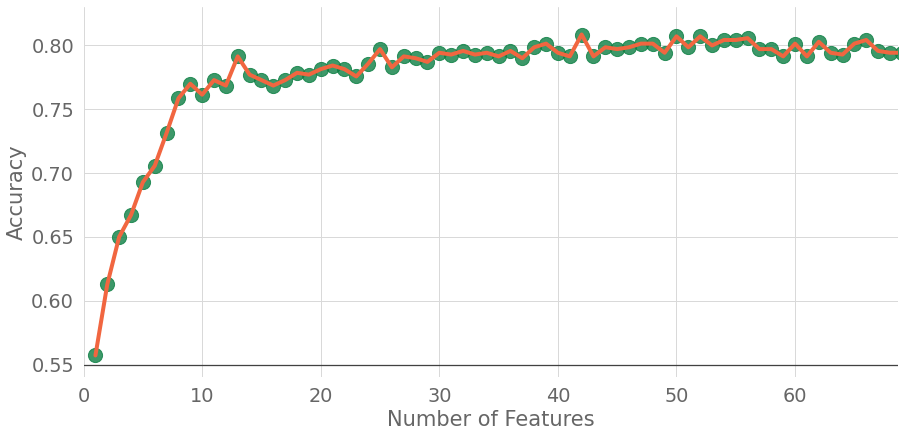

In [30]:
###############################################################################
#                4f. Feature Selection: RFECV performance curve               #
###############################################################################
# Get Performance Data
performance_curve = {'Number of Features': list(range(1, len(fs.rfecv.grid_scores_) + 1)),
                    'Accuracy': fs.rfecv.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               "grid.linestyle": '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4'})
colors = sns.color_palette('RdYlGn', 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = 'Number of Features', y = 'Accuracy', data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve['Number of Features'], y = performance_curve['Accuracy'],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0, len(fs.rfecv.grid_scores_)/1.5)
plt.ylim(0.54, 0.83)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.55, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig('Moderately to Highly Correated + RFECV performance_curve.png', dpi = 1080)


## In Figure 14, the model’s performance as a function of a number of features is shown. As you can see, the performance peak’s around 40 features with an accuracy of about 0.80. Since the number of selected features are about 50 (see Figure 13), we can conclude that the RFECV Sklearn object overestimates the minimum number of features we need to maximize the model’s performance. In my opinion, you be better off if you simply selected the top 13 ranked features where the model’s accuracy is about 79%. However, the RFECV Skelarn object does provide you with that information. If you were eager to know what were the top 13 ranked features, you will need to write your own version of the RFE algorithm.

# Building a Feature Selection Pipeline

## In the previous section, we learn that we need to be cautious and alert to the dangers of automatic feature selection methods. By applying them and then trusting the results blindly you might end up making terrible miscalculation. Furthermore, not a single feature selection algorithm produced the results that we wanted — selected only informative and critical features.

## To improve our feature selection, we can apply feature selection algorithms as a series of steps. For example, we can first remove moderate to highly correlated features (line 11) and then apply the RFE method as shown in Script 5a.

In [31]:
###############################################################################
#       5a. Feature Selection Pipeline: Removing Highly Correlated + RFE      #
###############################################################################
# Initiate classifier instance
estimator = RandomForestClassifier(random_state = 42)

# Update classifier parameters
estimator.set_params(**best_params)

# Define steps
step1 = {'Correlated Features': {'correlation_threshold': 0.80}}

step2 = {'RFECV Features': {'cv': 5,
                            'estimator': estimator,
                            'step': 1,
                            'scoring': 'accuracy',
                            'verbose': 50}}

# Place steps in a list in the order you want them execute it
steps = [step1, step2]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)

Removing Correlated Features
['Redundant 28', 'Redundant 29', 'Redundant 33', 'Redundant 35', 'Redundant 52', 'Redundant 54', 'Redundant 55', 'Redundant 59', 'Repeated 61', 'Repeated 62', 'Repeated 63', 'Repeated 64', 'Repeated 65', 'Repeated 66', 'Repeated 67', 'Repeated 68', 'Repeated 69', 'Repeated 70', 'Repeated 71', 'Repeated 72', 'Repeated 73', 'Repeated 74', 'Repeated 75', 'Repeated 76', 'Repeated 77', 'Repeated 78', 'Repeated 79', 'Repeated 80', 'Repeated 81', 'Repeated 82', 'Repeated 83', 'Repeated 84', 'Repeated 85']

Selecting RFECV features
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting e

In [42]:
Image(url= "https://miro.medium.com/max/1400/1*cSmqHM0vFYwVPmJCyu70JA.png")

## This time, in the selected features we have 8 informative, all 3 critical features, and 20 redundant features. These are the best results we have obtained by far but let us investigate a bit more further. Remember, that the FeatureSelector object saves the fitted RFECV object in its rfecv attribute.

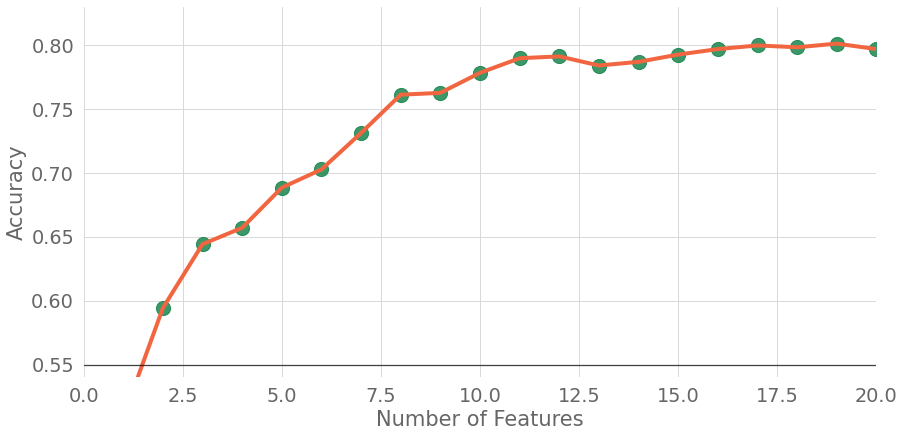

In [43]:
###############################################################################
#                4f1. Feature Selection: RFECV performance curve               #
###############################################################################
# Get Performance Data
performance_curve = {'Number of Features': list(range(1, len(fs.rfecv.grid_scores_) + 1)),
                    'Accuracy': fs.rfecv.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               "grid.linestyle": '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4'})
colors = sns.color_palette('RdYlGn', 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = 'Number of Features', y = 'Accuracy', data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve['Number of Features'], y = performance_curve['Accuracy'],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0, len(fs.rfecv.grid_scores_)/1.5)
plt.ylim(0.54, 0.83)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.55, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig('Moderately to Highly Correated + RFECV performance_curve.png', dpi = 1080)

## So we can already see from the performance curve that model’s performance peaks around 20 features. Additionally, we can conclude that 15 features will be enough to get a high performance. We now evaluate the model’s performance using the selected features in Script 5b.

In [32]:
###############################################################################
#       5b. Feature Selection: Model evaluation with selected features        #
###############################################################################
# Initiate classifier instance
estimator = RandomForestClassifier(random_state=42)

# Update classifier parameters
estimator.set_params(**best_params)

# Get selected features
X_selected_train = fs.transform(X_all_train)
X_selected_test = fs.transform(X_all_test)

# Fit classifier
estimator.fit(X_selected_train, y_all_train)

# Make predictions
y_pred_train = estimator.predict(X_selected_train)
y_pred_test = estimator.predict(X_selected_test)

# Measure performance
accuracy_train = metrics.accuracy_score(y_all_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_all_test, y_pred_test)

# Message to user
print(f'The accuracy of the classifier on the train set was: {accuracy_train*100}')
print(f'The accuracy of the classifier on the test set was: {accuracy_test*100}')


The accuracy of the classifier on the train set was: 95.14285714285714
The accuracy of the classifier on the test set was: 84.33333333333334


## From the output of Script 5b, we can see that we increased the accuracy in the training set to 84%. Slowly but surely we have made gains. You can use Script 4e to tune the model again and see if you get any more gains in performance.

# Closing Remarks

So how the hell do we design a feature selection pipeline that will yield all the informative and critical features and no redundant or useless features? Well, the short answer is that I don’t know. If you were to figure this problem out, you could take your algorithm quite literally to bank. The question you should be asking is, “Do I really need to determine the most useful features or do I want to train a model with the smallest subset of features?” If your answer is “to determine the most useful features” the methods presented here will shed some light on your search for the best features. However, if you only care about training the best possible model with a smaller subset of features, the feature selection algorithms presented here will do the job.

If you will like to use the feature selection tool, make sure that you have it on your working directory like so:

## Before you use it to select features ensure the following conditions are met:

   *  Load your data and encode all categorical variables.
   *  Take care of any missing values or outliers. If you don’t, you might get a nasty error.
   * Store the feature matrix X into a pandas DataFrame object. The target variable y should be a numpy array.

## Once you prepare your data you can use Script 6a to guide your feature selection process. You will need to experiment to determine what feature selection algorithms to apply. In Script 6a, we start by tuning our model (line 5–29), then we define four feature selection methods and apply them (line 32–56). We then use the selected features to train a model and evaluate its performance (line 59–75).

In [33]:

###############################################################################
#    6a. Feature Selection: Tune RF, Select Features, Evaluate Performance    #
###############################################################################
# Initiate classifier instance
estimator = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = { 'n_estimators': [200],
                'class_weight': [None, 'balanced'],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [3, 4, 5, 6, 7, 8],
                'min_samples_split': [0.005, 0.01, 0.05, 0.10],
                'min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
                'criterion' :['gini', 'entropy']     ,
                'n_jobs': [-1]
                 }

# Initialize GridSearch object
gscv = GridSearchCV(estimator, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = 'accuracy')

# Fit gscv
gscv.fit(X_all_train, y_all_train)

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_

# Update classifier parameters
estimator.set_params(**best_params)

# Define steps
step1 = {'Constant Features': {'frac_constant_values': 0.95}}

step2 = {'Correlated Features': {'correlation_threshold': 0.80}}

step3 = {'Relevant Features': {'cv': 5,
                               'estimator': estimator,
                                'n_estimators': 1000,
                                'max_iter': 50,
                                'verbose': 0,
                                'random_state': 42}}

step4 = {'RFECV Features': {'cv': 5,
                            'estimator': estimator,
                            'step': 1,
                            'scoring': 'accuracy',
                            'verbose': 50}}

# Place steps in a list in the order you want them execute it
steps = [step1, step2, step3, step4]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected_train = fs.transform(X_all_train)
X_selected_test = fs.transform(X_all_test)

# Fit classifier
estimator.fit(X_selected_train, y_all_train)

# Make predictions
y_pred_train = estimator.predict(X_selected_train)
y_pred_test = estimator.predict(X_selected_test)

# Measure performance
accuracy_train = metrics.accuracy_score(y_all_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_all_test, y_pred_test)

# Message to user
print(f'The accuracy of the classifier on the train set was: {accuracy_train*100}')
print(f'The accuracy of the classifier on the test set was: {accuracy_test*100}')

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 42.7min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 50.7min finished


Removing Constant Features
[]

Removing Correlated Features
['Redundant 28', 'Redundant 29', 'Redundant 33', 'Redundant 35', 'Redundant 52', 'Redundant 54', 'Redundant 55', 'Redundant 59', 'Repeated 61', 'Repeated 62', 'Repeated 63', 'Repeated 64', 'Repeated 65', 'Repeated 66', 'Repeated 67', 'Repeated 68', 'Repeated 69', 'Repeated 70', 'Repeated 71', 'Repeated 72', 'Repeated 73', 'Repeated 74', 'Repeated 75', 'Repeated 76', 'Repeated 77', 'Repeated 78', 'Repeated 79', 'Repeated 80', 'Repeated 81', 'Repeated 82', 'Repeated 83', 'Repeated 84', 'Repeated 85']

Selecting relevant features
Progress: |██████████████████████████████████████████████████| 100.0% Complete
['Informative 1', 'Informative 3', 'Informative 4', 'Informative 7', 'Informative 9', 'Redundant 11', 'Redundant 12', 'Redundant 13', 'Redundant 14', 'Redundant 15', 'Redundant 19', 'Redundant 21', 'Redundant 24', 'Redundant 25', 'Redundant 31', 'Redundant 36', 'Redundant 37', 'Redundant 39', 'Redundant 41', 'Redundant 42', 'R

In [45]:
X_selected_train.shape,X_all_train.shape

((700, 25), (700, 103))

In [44]:

X_selected_test.shape, X_all_test.shape

((300, 25), (300, 103))

In [47]:
fs

In [48]:
fs.rfecv.grid_scores_

array([0.50857143, 0.59428571, 0.64428571, 0.65714286, 0.68857143,
       0.70285714, 0.73142857, 0.76142857, 0.76285714, 0.77857143,
       0.79      , 0.79142857, 0.78428571, 0.78714286, 0.79285714,
       0.79714286, 0.8       , 0.79857143, 0.80142857, 0.79714286,
       0.80142857, 0.80142857, 0.79571429, 0.79285714, 0.80714286,
       0.79571429, 0.80142857, 0.80428571, 0.80285714, 0.80571429])

In [49]:
performance_curve

,Number of Features,Accuracy
0,1,0.508571
1,2,0.594286
2,3,0.644286
3,4,0.657143
4,5,0.688571
5,6,0.702857
6,7,0.731429
7,8,0.761429
8,9,0.762857
9,10,0.778571


# 25 features give the best CV accuracy, that's why the final selected features are 25!

In [50]:
len(fs.rfecv.grid_scores_)/1.5

20.0

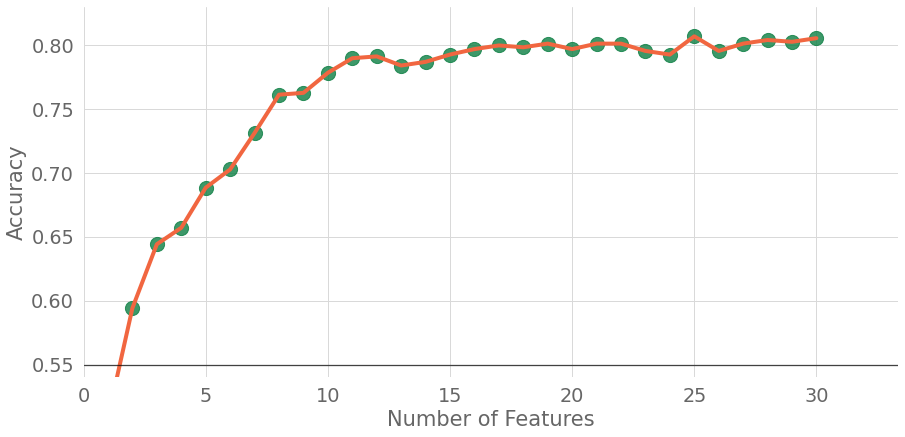

In [52]:
###############################################################################
#                 Feature Selection: RFECV performance curve               #
###############################################################################
# Get Performance Data
performance_curve = {'Number of Features': list(range(1, len(fs.rfecv.grid_scores_) + 1)),
                    'Accuracy': fs.rfecv.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               "grid.linestyle": '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4'})
colors = sns.color_palette('RdYlGn', 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = 'Number of Features', y = 'Accuracy', data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve['Number of Features'], y = performance_curve['Accuracy'],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0, len(fs.rfecv.grid_scores_)/0.9)
plt.ylim(0.54, 0.83)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.55, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig('Moderately to Highly Correated + RFECV performance_curve.png', dpi = 1080)